**Einops** is a Python package that simplifies tensor operations, inspired by Einstein summation. It provides flexible functions for rearranging, reducing, and repeating tensors, making code cleaner and more intuitive

In [6]:
pip install einops vit_pytorch linformer

The following code checks if CUDA (a parallel computing platform) is available. If it is, it prints “CUDA is available!”; otherwise, it prints “CUDA is not available.”

In [7]:
import torch

if torch.cuda.is_available():
  print("CUDA is available!")
else:
  print("CUDA is not available.")


CUDA is available!


Importing packages which are required for the project as follows:
torch: The core PyTorch library for tensor computation and deep learning.

**torch.nn:** Provides tools for defining and training neural networks (such as layers, loss functions, and optimizers).

**torch.optim:** Contains various optimization algorithms (e.g., SGD, Adam) for updating model parameters during training.

**torchvision.datasets:** A module for loading standard datasets (like MNIST) for computer vision tasks.

**torchvision.transforms:** Offers image transformations (e.g., resizing, normalization) for data preprocessing.

**datasets:** Part of torchvision, it provides access to popular datasets.

**transforms:** Also part of torchvision, it handles data transformations.

**DataLoader:** Helps create data iterators for efficient batch processing during training.
tqdm: A progress bar library for tracking loops and tasks.

**torch.nn.functional:** Contains functional versions of neural network layers (e.g., activation functions).

**CrossEntropyLoss:** A common loss function for multi-class classification tasks.

**Adam:** An optimization algorithm based on adaptive moment estimation.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from __future__ import print_function
import glob
from itertools import chain
import os
import random
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

**transforms.Compose:** This function creates a sequence of data transformations. In this case, it combines two transformations: converting the data to a tensor (transforms.ToTensor()) and normalizing it to a range of [-1, 1] (transforms.Normalize()).

**trainset and testset:** These are datasets containing MNIST images for training and testing, respectively. The data is normalized using the specified transformation.

**trainloader and testloader:** These are data loaders that allow efficient batch processing during training and testing.

In [9]:
# Defining the transform to normalize the data
transform = transforms.Compose (
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] # Normalize to [-1, 1]
)

# Loading the training and test datasets
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)


100%|██████████| 170498071/170498071 [00:02<00:00, 77933676.58it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Defined the categories of images and labelled in a classes

In [10]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In order to retrieve a batch of images and their accompanying labels, it initializes an iterator for the training data loader (trainloader). The batch type (images), batch shape (batch size, channels, height, and width), and label shape are then printed.

In [11]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

**data_iter = iter(train_loader):** Creates an iterator from the train_loader.
images is a tensor containing the batch of images.

**images.shape** represents the tensor dimensions: batch size (b), channels (c), height (h), and width (w).

**labels.shape** indicates the shape of the tensor containing the corresponding labels.

Here's a 4-line explanation of the code:

1. **Imports:** Gets tools for plotting (matplotlib) and numerical data (numpy).
2. **Grabs images and labels:** Fetches a batch of images and their corresponding labels from a training dataset.
3. **Inspects an image:** Displays the first image from the batch and prints its shape.
4. **Reveals its label:** Prints the class associated with the first image's label.

torch.Size([64, 3, 32, 32])


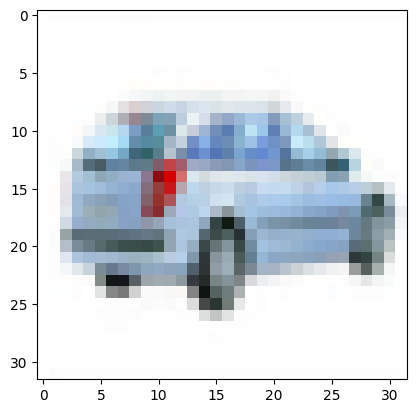

The first Label is: car


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
# Show images
imshow(images[0]) # Show the 1st image of the batch

# Print the label of the first image
print('The first Label is:', classes[labels[0]])

The code initializes a GPT (Generative Pre-trained Transformer) model specifically tailored for image data processing. It creates a model with 12 layers, each containing 12 attention heads and an embedding size of 768. The model does not include biases and uses a dropout rate of 0.0. Additionally, it is configured with a patch size of 16x16, 3 input channels (RGB), 4 patches per image, and aims to classify images into 10 classes. The model is initialized from scratch and is set to utilize the GPU ('cuda') for computational efficiency during training and inference

In [13]:
import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

class LayerNorm(nn.Module):

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)

        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout

        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")

            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()


        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:

            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:

            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    patch_size: int = 16
    channels: int = 3
    num_patches: int = 4
    num_classes: int = 10
    bias: bool = True

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.patch_embeddings = nn.Conv2d(in_channels=config.channels,
                                      out_channels=config.n_embd,
                                      kernel_size=(config.patch_size, config.patch_size),
                                      stride=(config.patch_size, config.patch_size)),
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.n_embd)),
        self.pos_embeddings = nn.Parameter(torch.zeros(1, 1 + config.num_patches, config.n_embd)),
        self.drop = nn.Dropout(config.dropout),
        self.h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
        self.ln_f = LayerNorm(config.n_embd, bias=config.bias)

        self.lm_head = nn.Linear(config.n_embd, config.num_classes, bias=False)
        self.apply(self._init_weights)

        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))
    def get_num_params(self, non_embedding=True):

        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:

            n_params -= self.transformer.pos_embeddings.numel()
        return n_params

    def _init_weights(self, module):

        if isinstance(module, nn.Linear) or isinstance(module, nn.Embedding):

            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
              module.bias.data.zero_()

        elif isinstance(module, nn.LayerNorm):

            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, idx, targets=None):
        device = idx.device
        b, c, h, w = idx.size()


        # Patch embedding
        patch_emb = self.patch_embeddings(idx)
        patch_emb = patch_emb.flatten(2).transpose(1, 2)

        # cls token prepend
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        patch_emb = torch.cat([cls_tokens, patch_emb], dim=1)

        # Positional embedding
        patch_pos_emb = patch_emb + self.pos_embeddings[:, :x.size(1)]
        x = self.drop(patch_pos_emb)
        for block in self.h:
            x = block(x)
        x = self.ln_f(x)

        if targets is not None:

            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:

            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss

    def crop_block_size(self, block_size):
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {}

        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024),
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280),
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600),
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257
        config_args['block_size'] = 1024
        config_args['bias'] = True

        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']

        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')]


        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()


        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')]
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')]
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']

        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):

                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:

                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):

        param_dict = {pn: p for pn, p in self.named_parameters()}

        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}

        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

It initializes a new GPT model for image processing from scratch with specific configurations: 12 layers, 12 attention heads, 768 embedding dimensions, no biases, no dropout, 16x16 patch size, 3 input channels (RGB), 4 patches per image, and 10 output classes. It prints a message indicating that it's initializing a new model from scratch and creates the model instance using these configurations on the GPU ('cuda').

In [14]:
init_from = 'scratch'
device = 'cuda'

model_args = dict(
    n_layer=12,
    n_head=12,
    n_embd=768,
    bias=False,
    dropout=0.0,
    patch_size=16,
    channels=3,
    num_patches=4,
    num_classes=10
)

if init_from == 'scratch':
    # init a new model from scratch
    print("Initializing a new model from scratch")
    # determine the vocab size we'll use for from-scratch training
    gptconf = GPTConfig(**model_args)
    model = GPT(gptconf)

Initializing a new model from scratch


 It ensures that the model’s computations are performed on the specified device during training and inference.

In [15]:
model.to(device)

GPT(
  (ln_f): LayerNorm()
  (lm_head): Linear(in_features=768, out_features=10, bias=False)
)

**Loss Function:** nn.CrossEntropyLoss() computes the negative log likelihood loss for multi-class classification tasks.

**Optimizer:** optim.Adam(model.parameters(), lr=0.001) initializes the Adam optimizer with a learning rate of 0.001.

**Epochs:** epochs = 2 specifies the number of training epochs.

In [16]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# epoch
epochs = 2


This code calculates the accuracy and loss metrics for the training and validation datasets during a training loop that lasts for the chosen number of epochs. For every historical period:

It uses tqdm to visualize the progress as it iterates through the training data batches.


It delivers the labels and data to the designated device (such as a GPU) so that it can be processed.

It computes the loss and predictions (logits) of the model, backpropagates, and uses the optimizer to adjust the model's parameters.

It averages over batches to calculate the training accuracy and loss.

In a similar manner, it calculates validation accuracy and loss, assesses the model using the validation data, and reports the progress for every epoch.

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_loader)
            epoch_val_loss += val_loss / len(test_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/938 [00:00<?, ?it/s]

TypeError: 'tuple' object is not callable

**ViT model**

The function pair(t) ensures that the conversion of its input, t, into a tuple. It returns t unchanged if t is already a tuple. If not, it generates a tuple using t twice, guaranteeing that the result is always a tuple—either with a single element repeated or, if t was previously a tuple, with the original contents.

In [18]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

The Vision Transformer (ViT) model architecture for image categorization is implemented by the ViT class. Patch embeddings, positional embeddings, the transformer encoder, and a multi-layer perceptron (MLP) head for classification are some of its constituent parts.

It adds positional embeddings and transforms picture patches into embeddings. processes the embeddings using a transformer encoder.

uses the class token or mean pooling, depending on the pooling type ('cls' or'mean') that has been selected.

creates the final class predictions by using an MLP head for classification.

In [19]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, transformer, pool = 'cls', channels = 3):
        super().__init__()
        image_size_h, image_size_w = pair(image_size)
        assert image_size_h % patch_size == 0 and image_size_w % patch_size == 0, 'image dimensions must be divisible by the patch size'
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        num_patches = (image_size_h // patch_size) * (image_size_w // patch_size)
        patch_dim = channels * patch_size ** 2

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim)
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = transformer

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

The follwing defines an efficient transformer model architecture called Linformer. It has the following properties:

Input dimension: 128

Sequence length: 49+1 (7x7 patches + 1 cls-token)

Depth: 12 layers

Number of attention heads: 8

Key dimension: 64

In [20]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

 It checks whether a CUDA-compatible GPU is available. If so, it sets the device to “cuda” (for GPU acceleration). Otherwise, it defaults to “cpu” (for CPU-based computations). The selected device determines where tensor operations and model training/inference occur.

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

A Vision Transformer (ViT) is initially initialized with certain settings by the model variable:

With a 128x128 embedding dimension, it can handle 224x224 images with 32x32 patches.

The model uses the supplied efficient_transformer to classify data into ten types.

It uses three-channel pictures for operation, and it moves to the GPU or CPU depending on what is available.

In [22]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=10,
    transformer=efficient_transformer,
    channels=3,
).to(device)

Batch Size: The number of data samples processed in one iteration during training, set to 64.

Epochs: The number of times the entire dataset is passed forward and backward through the model during training, set to 2.

Learning Rate (lr): The rate at which the model parameters are updated during optimization, set to 3e-5 (0.00003).

Gamma: The factor by which the learning rate is reduced after each epoch, set to 0.7, which reduces the learning rate by 30% after each epoch.

Seed: The random seed used for initializing the random number generator, set to 42 for reproducibility of results.

In [23]:
# Training settings
batch_size = 64
epochs = 2
lr = 3e-5
gamma = 0.7
seed = 42

Loss Function (criterion): It defines the loss function used for training the model. In this case, it's nn.CrossEntropyLoss(), commonly used for classification tasks.

Optimizer (optimizer): It defines the optimization algorithm used to update the model parameters during training. Here, it's optim.Adam with a learning rate (lr) of 3e-5 (0.00003), optimizing the parameters of the model.

Scheduler (scheduler): It defines a learning rate scheduler that adjusts the learning rate during training. The StepLR scheduler reduces the learning rate by a factor of gamma (0.7 in this case) every step_size (1 epoch) to improve convergence.

In [24]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

This code tells that Within the designated number of epochs, it loops over the batches of training data (from train_loader). It transfers the data and labels to the designated GPU device for every batch, computes the model's output, computes the loss using the established criterion (CrossEntropyLoss), updates the model's parameters via backpropagation using the optimizer (Adam), and computes the training accuracy. It calculates validation loss and accuracy by assessing the model's performance on the validation data (from test_loader) at the end of each epoch. Following every epoch, the training progress—which includes the loss, accuracy, validation accuracy, and validation loss—is printed.

In [25]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(test_loader)
            epoch_val_loss += val_loss / len(test_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

Epoch : 1 - loss : 1.9595 - acc: 0.2796 - val_loss : 1.7139 - val_acc: 0.3856

Epoch : 2 - loss : 1.6393 - acc: 0.4171 - val_loss : 1.5789 - val_acc: 0.4370



This code illustrates about a trained deep learning model to visualize and predict a random test image. From the test loader dataset, a test image and its true label are first chosen at random. Next, it uses matplotlib to display the image, putting the true label in the title. The model is used to predict the label of the image after preprocessing it and transferring it to the designated GPU. This is done by setting the model to evaluation mode (model.eval()). Taking the class index from the model's output that has the highest probability will yield the projected label. In the end, it prints the predicted label as well as the genuine label for comparison.

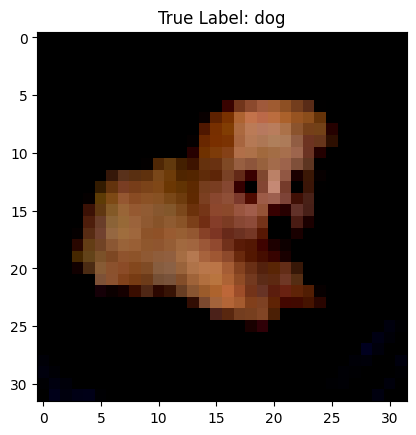

Actual Label is: dog
Model Predicted Label: cat


In [26]:
import matplotlib.pyplot as plt
import random

# Selecting a random test image
img, true_label = random.choice(list(test_loader.dataset))


# For Displaying the image
plt.imshow(img.permute(1, 2, 0))  # Adjust for matplotlib
plt.title(f"True Label: {classes[true_label]}")
plt.show()

# Preprocessing and predict
img = img.unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    output = model(img)
    predicted_label = output.argmax(dim=1).item()

# Printing the actual and the predicted labels
print(f"Actual Label is: {classes[true_label]}")
print(f"Model Predicted Label: {classes[predicted_label]}")
